In [13]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Part 1: Prepare the Data

In [14]:
# Load the data
file_path = Path("Instructions/myopia.csv")
df = pd.read_csv(file_path)
#Save labels and remove the "MYOPIC" column from the dataset.
labels = df["MYOPIC"]
df = df.drop(columns = ["MYOPIC"])
df.head()

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0


In [15]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['AGE', 'SPHEQ', 'AL', 'ACD', 'LT', 'VCD', 'SPORTHR', 'READHR', 'COMPHR',
       'STUDYHR', 'TVHR', 'DIOPTERHR']])
#create new df with the scaled data
new_df = pd.DataFrame(scaled_data, columns=df.columns[:-2])
#add binary cols back in
new_df["MOMMY"]=df["MOMMY"]
new_df["DADMY"]=df["DADMY"]
new_df.head()

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,-0.420219,-1.363917,-0.892861,0.483784,-0.281443,-1.019792,4.150661,1.697450,-0.689311,-0.672996,0.184058,0.498304,1,1
1,-0.420219,-0.308612,-0.171840,0.535910,-0.967997,-0.130763,-0.998898,-0.912062,-0.361875,-0.221409,-0.340932,-0.875088,1,1
2,-0.420219,0.604386,-0.009977,-0.506628,-0.177812,0.215809,0.257092,-0.912062,-0.034439,-0.672996,0.184058,-0.750234,0,0
3,-0.420219,-0.441325,-0.436703,1.230936,0.456927,-0.974587,0.759488,2.676017,-0.689311,-0.672996,-0.865922,0.685585,0,1
4,-1.823978,-0.166306,1.167204,0.422970,-0.566427,1.180178,0.257092,-0.912062,-0.689311,-0.672996,-0.865922,-1.374503,1,0


# Part 2: Dimensionality Reduction

### PCA

In [16]:
# Initialize PCA model
pca = PCA(n_components=.90)
myopia_pca = pca.fit_transform(new_df)
#check dimensionality reduction
myopia_pca.shape

(618, 9)

### t-SNE

In [17]:
#run t-SNE on the output of the PCA reduction
tsne = TSNE(learning_rate=250)
tsne_features = tsne.fit_transform(myopia_pca)
#check dimensionality reduction
tsne_features.shape

(618, 2)

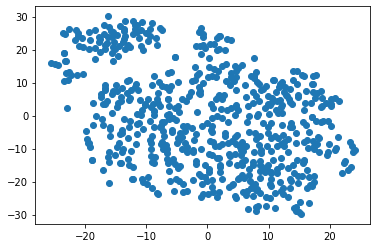

In [18]:
#Plot results
plt.scatter(tsne_features[:,0], tsne_features[:,1])
plt.show()

# Part 3: K-Means Clustering

In [19]:
#Create an elbow plot to identify the best number of clusters. 
#Use a for loop to determine the inertia for each k between 1 through 10.
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(tsne_features)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.head()

C:\Users\rhian\anaconda3_2\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,k,inertia
0,1,223954.453125
1,2,114716.453125
2,3,78867.585938
3,4,51745.738281
4,5,42132.695312


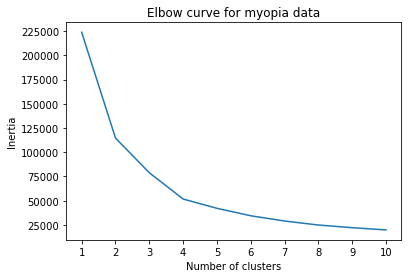

In [20]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for myopia data')
plt.savefig("Visualizations/K-MeansElbow.png")
plt.show()

#Elbow of the curve appears to be at k=4

In [21]:
#create visualization by coloring the scatterplot with the determined K-means clusters
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=42)
# Train the model
model.fit(tsne_features)
# Predict clusters
predictions = model.predict(tsne_features)
cluster_labels = model.labels_

In [22]:
#create new df with cluster labels
clustered_df = pd.DataFrame(tsne_features, columns=["Comp1", "Comp2"])
clustered_df["Cluster"] = cluster_labels
clustered_df.head()

,Comp1,Comp2,Cluster
0,-18.926888,-13.391211,2
1,11.580435,0.806909,1
2,17.482117,-10.253497,3
3,-15.185707,-12.075230,2
4,14.792466,6.155723,1


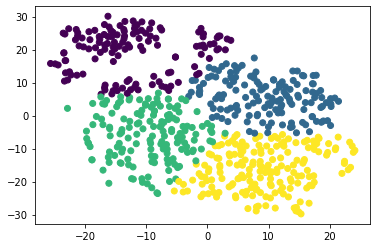

In [23]:
#redo scatterplot with new clusters as colors
plt.scatter(clustered_df["Comp1"], clustered_df["Comp2"], c=clustered_df["Cluster"])
plt.savefig("Visualizations/Cluster_Vis.png")
plt.show()


### Part 4: Recommendation can be found in README file